# Allanvariance Analysis of IMU Sensor

References:
- https://en.wikipedia.org/wiki/Allan_variance
- https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as av

In [2]:
stat_acc_df = pd.read_csv("../data/stationary_acc.csv")
stat_gyr_df = pd.read_csv("../data/stationary_gyr.csv")

In [15]:
def find_log_slope(xdat, ydat, i0=None, i1=None):
    assert len(ydat) == len(xdat)
    if i0 is None:
        i0 = len(ydat) // 2
    if i1 is None:
        i1 = len(ydat) - 1
    y1 = ydat[i1]
    y0 = ydat[i0]
    x1 = xdat[i1]
    x0 = xdat[i0]
    y1log = np.log10(y1)
    y0log = np.log10(y0)
    x1log = np.log10(x1)
    x0log = np.log10(x0)
    return (y1log - y0log) / (x1log - x0log)

## Accelerometer White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Accelerometer's yaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

In [3]:
stat_acc_df.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
0,0.069651,0.080758,-0.120838,9.752547
1,0.119651,0.085543,-0.101695,9.756734
2,0.169651,0.090329,-0.106481,9.747163
3,0.219651,0.066401,-0.105882,9.766306
4,0.269651,0.080758,-0.111266,9.751948


In [4]:
stat_acc_df.describe()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.244651,0.076074,-0.116533,9.757696
std,724.697275,0.007860,0.009195,0.011075
min,0.069651,-0.141775,-0.498305,9.490533
25%,627.657151,0.071186,-0.123230,9.751350
50%,1255.244651,0.075972,-0.116650,9.757333
75%,1882.832151,0.080758,-0.110668,9.766306
max,2510.419651,0.185444,0.115454,10.130613


In [5]:
accel_time_vec = stat_acc_df.loc[:, 'Time (s)'].to_numpy()
accel_yaxis_vec = stat_acc_df.loc[:, 'Acceleration y (m/s^2)'].to_numpy()
accel_time_vec.shape, accel_yaxis_vec.shape

((50208,), (50208,))

In [ ]:
# Find sampling frequency and period.
T = accel_time_vec[1] - accel_time_vec[0]
Fs = 1 / T
f"Sampling properties: {T}s, {Fs}Hz"

'Sampling properties: 0.05s, 20.0Hz'

In [7]:
# Integrate to find speed.
vely_vec = np.cumsum(accel_yaxis_vec) * T

In [9]:
accel_taus, accel_adevs, _, _ = av.oadev(vely_vec, rate=Fs, taus="octave")
accel_taus.shape, accel_adevs.shape

((15,), (15,))

Text(0.5, 0, '$\\tau$ (s)')

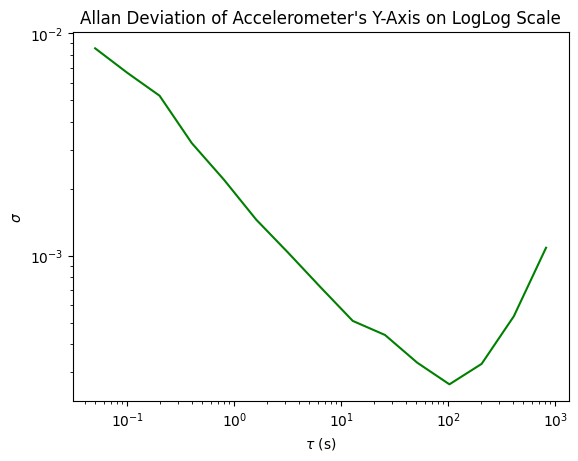

In [14]:
plt.loglog(accel_taus, accel_adevs, 'g')
plt.title("Allan Deviation of Accelerometer's Y-Axis on LogLog Scale")
plt.ylabel("$\\sigma$")
plt.xlabel("$\\tau$ (s)")

In [21]:
f"Slope: {float(find_log_slope(accel_taus, accel_adevs, 2, 10))}"

'Slope: -0.4983117270444709'

In [25]:
# Find indices where slope is about -0.5.
slope = -0.5
accel_log_taus = np.log10(accel_taus)
accel_log_adevs = np.log10(accel_adevs)
accel_dlogadev = np.diff(accel_log_adevs) / np.diff(accel_log_taus)
i = np.argmin(accel_dlogadev - slope)
i

np.int64(2)

In [27]:
# Find y-intercept of line equation: y = mx + b => b = y - mx.
b = accel_log_adevs[i] - slope*accel_log_taus[i]
b

np.float64(-2.630366179661934)

In [29]:
# Get log line points.
N = np.pow(10, slope * np.log10(1) + b)
accel_line_y = N / np.sqrt(accel_taus)
accel_line_y.shape

(15,)

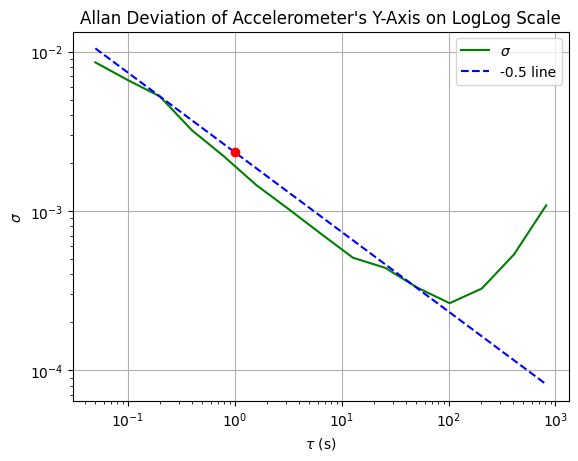

In [48]:
plt.style.use("default")
plt.title("Allan Deviation of Accelerometer's Y-Axis on LogLog Scale")
plt.ylabel("$\\sigma$")
plt.xlabel("$\\tau$ (s)")
plt.loglog(accel_taus, accel_adevs, 'g', label="$\\sigma$")
plt.loglog(accel_taus, accel_line_y, '--b', label="-0.5 line")
plt.loglog(1, N, "or")
plt.grid(True)
plt.legend()

> As seen the white noise is approximately Gaussian.

## Gyro White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Gyro's zaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

In [50]:
stat_gyr_df.head()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
0,0.084551,0.000611,0.000764,-0.000305
1,0.134551,-0.003054,0.000764,-0.000305
2,0.184551,-0.001833,0.000764,-0.000305
3,0.234551,-0.000611,-0.000458,-0.000305
4,0.284551,0.001833,0.000764,-0.000305


In [51]:
stat_gyr_df.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.259551,-0.000013,0.000007,0.000009
std,724.697275,0.002788,0.001189,0.000714
min,0.084551,-0.357814,-0.092546,-0.002902
25%,627.672051,-0.000458,-0.000764,-0.000305
50%,1255.259551,-0.000305,0.000305,-0.000000
75%,1882.847051,0.000916,0.000458,0.000153
max,2510.434551,0.460440,0.063683,0.020922


In [52]:
gyro_time_vec = stat_gyr_df.loc[:, 'Time (s)'].to_numpy()
gyro_zaxis_vec = stat_gyr_df.loc[:, 'Gyroscope z (rad/s)'].to_numpy()
gyro_time_vec.shape, gyro_zaxis_vec.shape

((50208,), (50208,))

In [53]:
# Find sampling frequency and period.
T = gyro_time_vec[1] - gyro_time_vec[0]
Fs = 1 / T
f"Sampling properties: {T}s, {Fs}Hz"

'Sampling properties: 0.05s, 20.0Hz'

In [54]:
# Integrate to find angle.
theta_z_vec = np.cumsum(gyro_zaxis_vec) * T

In [55]:
gyro_taus, gyro_adevs, _, _ = av.oadev(theta_z_vec, rate=Fs, taus="octave")
gyro_taus.shape, gyro_adevs.shape

((15,), (15,))

Text(0.5, 0, '$\\tau$ (s)')

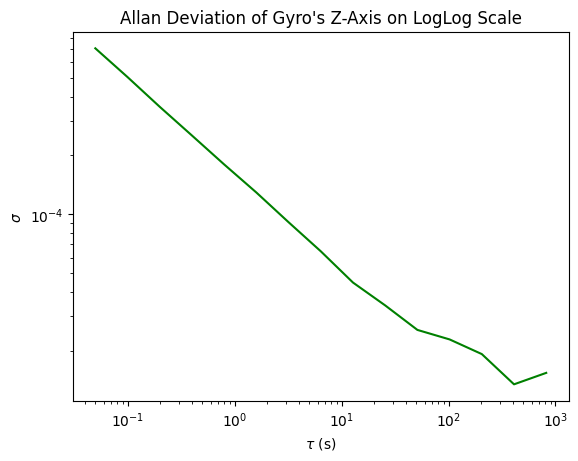

In [56]:
plt.loglog(gyro_taus, gyro_adevs, 'g')
plt.title("Allan Deviation of Gyro's Z-Axis on LogLog Scale")
plt.ylabel("$\\sigma$")
plt.xlabel("$\\tau$ (s)")

In [69]:
f"Slope: {float(find_log_slope(gyro_taus, gyro_adevs, 4, 8))}"

'Slope: -0.5019260375250464'

In [67]:
# Find indices where slope is about -0.5.
slope = -0.5
gyro_log_taus = np.log10(gyro_taus)
gyro_log_adevs = np.log10(gyro_adevs)
gyro_dlogadev = np.diff(gyro_log_adevs) / np.diff(gyro_log_taus)
i = np.argmin(gyro_dlogadev - slope)
i

np.int64(7)

In [70]:
# Find y-intercept of line equation: y = mx + b => b = y - mx.
b = gyro_log_adevs[i] - slope*gyro_log_taus[i]
b

np.float64(-3.7865745983530124)

In [71]:
# Get log line points.
N = np.pow(10, slope * np.log10(1) + b)
gyro_line_y = N / np.sqrt(gyro_taus)
gyro_line_y.shape

(15,)

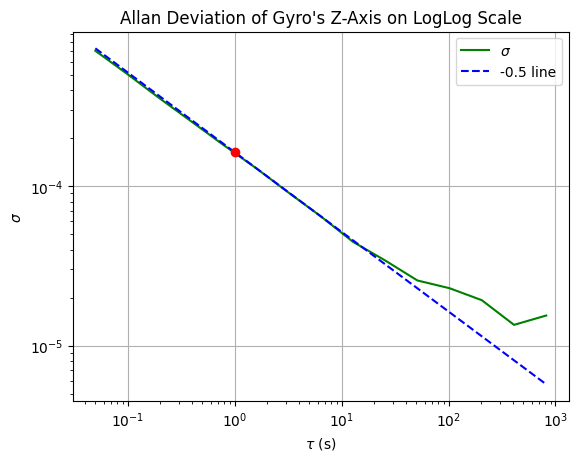

In [72]:
plt.style.use("default")
plt.title("Allan Deviation of Gyro's Z-Axis on LogLog Scale")
plt.ylabel("$\\sigma$")
plt.xlabel("$\\tau$ (s)")
plt.loglog(gyro_taus, gyro_adevs, 'g', label="$\\sigma$")
plt.loglog(gyro_taus, gyro_line_y, '--b', label="-0.5 line")
plt.loglog(1, N, "or")
plt.grid(True)
plt.legend()


> As seen the white noise is approximately Gaussian.